# Fine-tuning Models for Healthcare via Differentially-Private Synthetic Text, using Gretel and AWS

In this notebook, we show how private synthetic text can be used to fine-tune models for healthcare, a domain where data is highly sensitive and often cannot be used due to privacy concerns. In particular, we go through the following steps:

1. We show how to **fine-tune Gretel's GPT with differential privacy (DP)**, in order to generate synthetic data that does not leak anything sensitive from the original data.
2. This synthetic data is then used to **fine-tune a second model on Amazon Bedrock**, Claude 3.5 Haiku, that will be used for the downstream task we are interested in - generating clinical notes from transcripts.
3. Finally, we evaluate **how well the fine-tuned Haiku model does on the downstream task**, comparing it to the base model.

First let's set up calls to Bedrock. Make sure to fill the following variables correctly:

In [ ]:
# NOTE: fill this cell!
AWS_PROFILE_NAME =
AWS_REGION =

In [ ]:
import boto3
from botocore.exceptions import ClientError

DEFAULT_INST = "You are a helpful assistant."
BASE_MODEL_ID = "anthropic.claude-3-haiku-20240307-v1:0"

# Create a Bedrock runtime client in the AWS region you want to use.
boto3.setup_default_session(profile_name=AWS_PROFILE_NAME)
client = boto3.client("bedrock-runtime", region_name=AWS_REGION)

def call_bedrock(message, system=DEFAULT_INST, model_id=BASE_MODEL_ID):
    conversation = [
        {
            "role": "user",
            "content": [{"text": message}],
        }
    ]
    
    try:
        # Send the message to the model, using a basic inference configuration.
        response = client.converse(
            modelId=model_id,
            system=[{"text": system}],
            messages=conversation,
            inferenceConfig={"maxTokens": 512, "temperature": 0.5, "topP": 0.9},
            additionalModelRequestFields={}
        )
    
        # Extract and print the response text.
        response_text = response["output"]["message"]["content"][0]["text"]
        return response_text 
    
    except (ClientError, Exception) as e:
        print(f"ERROR: Can't invoke '{model_id}'. Reason: {e}")
        return None

## Loading dataset

For the proof-of-concept, we work with summarized notes, since samples in the original dataset can be quite long. We call Haiku to generate a summarized version of the first 10,000 samples in the dataset.

If you prefer, you can skip the next cell and run the one just after, which will load the summarized dataset from a S3 bucket.

In [ ]:
## SKIP TO DOWNLOAD RESULTS DIRECTLY

from glob import glob
from tqdm import tqdm

import pandas as pd
from datasets import load_dataset


# Load original dataset
original_dataset = load_dataset("AGBonnet/augmented-clinical-notes")

# Generate summaries
for i, s in tqdm(enumerate(original_dataset["train"][:10_000]["conversation"])):
    inst = f"Generate a shorter version of the following conversation."
    summary = call_bedrock(message=s, system=inst, model_id=BASE_MODEL_ID)
    with open(f'summaries/transcript_{i:05d}.txt', 'w') as fid:
        fid.write(summary)

# Load and process notes and transcripts
notes_files = glob('summaries/note*')
transcripts_files = glob('summaries/transcript*')

notes = []
for f in sorted(notes_files):
    if '.txt' in f:
        with open(f) as fid:
            content = fid.read()
            notes.append(content.split('\n')[-1])

transcripts = []
for f in sorted(transcripts_files):
    if '.txt' in f:
        with open(f) as fid:
            content = fid.read()
            transcript = [r for r in content.split('\n') if r.strip()]
            if 'short' in transcript[0]:  # remove intro if any
                transcript = transcript[1:]
            transcripts.append('\n'.join(transcript))

# Add notes and transcripts to dataframe
summaries = pd.DataFrame(columns=['conversation', 'note'])
summaries['conversation'] = transcripts
summaries['note'] = notes

summaries.to_csv('summaries.csv')

In [1]:
## DOWNLOAD RESULTS DIRECTLY HERE

import pandas as pd

summaries_link = "https://gretel-blueprints-pub.s3.us-west-2.amazonaws.com/gpt_x/synth_notes_blogpost/summaries.csv.gz"
summaries = pd.read_csv(summaries_link, compression="gzip")

Let's take a look at a sample from the dataset

In [2]:
orig_sample = summaries.iloc[0]
print(f"TRANSCRIPT:\n{orig_sample.conversation}\n\nNOTE:\n{orig_sample.note}")

TRANSCRIPT:
Doctor: What brings you to the Outpatient department today?
Patient: I have discomfort in my neck and lower back, and I'm having trouble standing up straight.
Doctor: Can you tell me more about the discomfort?
Patient: I have pain in my neck, and my head is always turned to the right and upwards. I also have sideways bending in my lower back.
Doctor: How long have you been experiencing this?
Patient: About four months, since I started taking olanzapine for my bipolar affective disorder.
Doctor: I see. I'll order some tests and we'll discuss further.

NOTE:
A 16-year-old girl presented with complaints of neck and lower back discomfort, restricted body movements, and abnormal posturing. She had been experiencing these symptoms for four months, which began after starting olanzapine for her bipolar affective disorder. The symptoms were characterized by sustained contraction of neck muscles, leading to abnormal head and neck movements, and required assistance with daily activiti

## Generating DP synthetic text

The next step is using the summarized dataset as input to Gretel's GPT, to obtain the private synthetic text. You can use a config such as follows

In [ ]:
YAML_CONFIG = """
schema_version: "1.0"
name: final-run-dp
models:
  - gpt_x:
      ref_data: {}
      pretrained_model: gretelai/Phi-3-mini-128k-instruct
      params:
        batch_size: 8
        epochs: 5
        steps: null
        weight_decay: 0.01
        warmup_steps: 100
        lr_scheduler: linear
        learning_rate: 0.008723427557099954
        max_tokens: 784
        gradient_accumulation_steps: 32
      peft_params:
        lora_r: 8
        lora_alpha_over_r: 1
        target_modules:
          - q_proj
          - v_proj
          - k_proj
          - o_proj
          - gate_proj
          - down_proj
          - up_proj
      privacy_params:
        dp: true
        epsilon: 8
        delta: auto
"""

This config can be used either in the Console, or through the SDK:

In [ ]:
## SNIPPET, SKIP TO DOWNLOAD RESULTS DIRECTLY

from gretel_client import Gretel

gretel = Gretel(
    project_name="new_project",
    api_key="prompt",
    endpoint="https://api.gretel.cloud",
)
trained = gretel.submit_train(base_config=YAML_CONFIG, data_source="summaries.csv")

After fine-tuning Gretel's GPT, we request more records to be generated:

In [ ]:
## SNIPPET, SKIP TO DOWNLOAD RESULTS DIRECTLY

generated = gretel.submit_generate(trained.model_id, num_records=10_000, maximum_text_length=784)
synth_data = generated.synthetic_data

Finally, we convert the synthetic data to the format that is expected by Bedrock:

In [ ]:
## SNIPPET, SKIP TO DOWNLOAD RESULTS DIRECTLY

import json
import re

pattern = r"^\*\*\* TRANSCRIPT \*\*\*\n\n(.*)\n\n\*\*\* NOTE \*\*\*\n\n(.*)$"
{"system": "<system message>", "messages":[{"role": "user", "content": "<user query>"},{"role": "assistant", "content": "<expected generated text>"}]}

processed, jsonl = 0, ''
for t in synth_data['text']:
    m = re.match(pattern, t, re.DOTALL)
    if m:
        instr = "You are given the transcript of a conversation between a doctor and a patient, and will generate a clinical note summarizing that conversation."
        prompt = m.group(1)
        completion = m.group(2)

        sample = {"system": instr, "messages": [{"role": "user", "content": prompt}, {"role": "assistant", "content": completion}]}
        jsonl += json.dumps(sample) + '\n'
        processed += 1

print(f'Processed {processed} valid entries')
with open('ftdata.jsonl', 'w') as fid:
    fid.write(jsonl)

The 10,000 synthetic records we generated will be used for fine-tuning Haiku for the downstream task. Instead of running the three cells above, you can fetch the synthetic data directly from a S3 bucket, using this snippet:

In [3]:
## DOWNLOAD RESULTS DIRECTLY HERE

import pandas as pd

ft_data_link = "https://gretel-blueprints-pub.s3.us-west-2.amazonaws.com/gpt_x/synth_notes_blogpost/ftdata.jsonl.gz"
ft_data = pd.read_json(ft_data_link, compression="gzip", lines=True)

In [4]:
import json

ft_sample = ft_data.iloc[0]
print(f"SYSTEM PROMPT:\n{ft_sample.system}\n\nMESSAGES:\n{json.dumps(ft_sample.messages, indent=2)}")

SYSTEM PROMPT:
You are given the transcript of a conversation between a doctor and a patient, and will generate a clinical note summarizing that conversation.

MESSAGES:
[
  {
    "role": "user",
    "content": "Doctor: Good morning, sir. I'm Dr. X. You're here for a follow-up on your oral lichenoid ulcerative leukoplakia. Can you tell me about your symptoms and the treatment you've received?\nPatient: I have a 3.5 cm ulcer on my tongue and roof of my mouth that's been growing for 2 years. It started as a red, painless ulcer and has turned white and non-healing. I was treated with antibiotics and steroid cream, but it didn't improve.\nDoctor: Okay, I'd like to take a closer look at the lesion. I'd like to take a biopsy to confirm the diagnosis.\nPatient: Okay, I understand.\nDoctor: The biopsy shows that the lesion is benign. I'd like to refer you to a specialist for further treatment.\nPatient: Okay, thank you.\nDoctor: You're welcome. If you have any other questions or concerns, plea

## Fine-tuning Haiku on AWS Bedrock

After uploading the synthetic data to a S3 bucket, we can proceed to fine-tune Haiku.

For this demo, we have used the Bedrock UI to perform the fine-tuning. Alternatively, the API can be used, see instructions [here](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_CreateModelCustomizationJob.html). In the screenshot below, you can see how the model customization job was set up. Note that we split the `ft_data.json` file above in two, one for training and one for validation, containing 9,900 and 100 samples respectively.

![Setting up Bedrock for fine-tuning](bedrock.png)

## Calling fine-tuned model

The fine-tuning job on Bedrock should take a few hours. After this is done, you will have to purchase provisioned throughput in order to use the model. It will give a model id, that you should add to the cell below.

In [ ]:
# NOTE: fill this cell!
FT_MODEL_ID = 

The function below calls either the base or fine-tuned model, depending on the argument, and asks it to generate a note given the transcript.

In [ ]:
def generate_and_print(transcript, original_note, id, finetuned=False, verbose=True):
    inst = "You are generating clinical notes given the transcript of a conversation between a doctor and a patient. Replace occurrences of age and gender with the tags [AGE] and [GENDER]."
    model_id = FT_MODEL_ID if finetuned else BASE_MODEL_ID 

    generated_note = call_bedrock(client, transcript, inst, model_id=model_id)
    with open(f'./generated{"" if finetuned else "_base"}/{id:04d}.txt', 'w') as fid:
        fid.write(generated_note)

    if verbose:
        print("TRANSCRIPT:\n", transcript)
        print("\nORIGINAL NOTE:\n", original_note)
        print("\nGENERATED NOTE:\n", generated_note)

We now call this function on the first 1,000 samples of the original dataset, so that we can compare the original note to the generated one. We do that for both the base and the fine-tuned models.
Remember that the fine-tuned model did not see any of this data, so practically speaking there is no data leakage.

Feel free to skip this cell, the following one should load all the generated data from a S3 bucket.

In [ ]:
## SNIPPET, SKIP TO DOWNLOAD RESULTS DIRECTLY

import os
from tqdm import trange

# Create folders
if not os.path.isdir('./generated'):
    os.mkdir('./generated')
if not os.path.isdir('./generated_base'):
    os.mkdir('./generated_base')

# Call both fine-tuned and base models to generate notes
for i in trange(1000):
    generate_and_print(*summaries.iloc[i].values[1:], id=i, finetuned=True, verbose=False)
    generate_and_print(*summaries.iloc[i].values[1:], id=i, finetuned=False, verbose=False)

In [5]:
## DOWNLOAD RESULTS DIRECTLY HERE

import requests
import tarfile

generated_link = "https://gretel-blueprints-pub.s3.us-west-2.amazonaws.com/gpt_x/synth_notes_blogpost/generated.tar.gz"

# This will download and extract generated notes, for both the base model and the fine-tuned model
with requests.get(generated_link, stream=True) as req, tarfile.open(fileobj=req.raw, mode="r:gz") as tarobj: 
    tarobj.extractall()

We read all the generated data into a list. Moreover, we create a "faked" version of the generated data, where the `[AGE]` and `[GENDER]` tags are replaced with fake data. This will be useful when computing metrics.

In [6]:
from glob import glob
from tqdm import tqdm

generated_ft = []
for filename in tqdm(sorted(glob('./generated/*'))):
    with open(filename, "r") as fid:
        generated_ft.append(fid.read())

generated_base = []
for filename in tqdm(sorted(glob('./generated_base/*'))):
    with open(filename, "r") as fid:
        generated_base.append(fid.read())

100%|██████████| 1000/1000 [00:02<00:00, 372.29it/s]


In [7]:
import numpy as np

generated_ft_faked = []
for s in generated_ft:
    age = str(np.random.choice(np.arange(12, 80))) + '-year old'
    gender = np.random.choice(['male', 'female'])
    generated_ft_faked.append(s.replace('[AGE]', age).replace('[GENDER]', gender))

generated_base_faked = []
for s in generated_base:
    age = str(np.random.choice(np.arange(12, 80))) + '-year old'
    gender = np.random.choice(['male', 'female'])
    generated_base_faked.append(s.replace('[AGE]', age).replace('[GENDER]', gender))

## Inspecting generated notes

Let's take a look at a specific transcript

In [8]:
print(f"TRANSCRIPT:\n{summaries.iloc[1].conversation}")

TRANSCRIPT:
Doctor: Hi, what brings you in today?
Patient: I have a dull ache in my right back and swelling for several weeks.
Doctor: Can you describe the pain? Have you had any health problems in the past?
Patient: It hurts more when I move. I had a thoracic trauma at work a year ago and was diagnosed with a simple fracture of the 9th right rib.
Doctor: Okay. We did a CT-scan and found a tumor in your thoracic wall. It's serious, but it didn't involve your lung or muscles. We need to do a biopsy to confirm the diagnosis.
Patient: Okay.
Doctor: We performed a biopsy and found no malignant cells. We then removed the tumor and three ribs where it was involved.
Patient: What's next?
Doctor: You need to follow up with us regularly to make sure everything is going well.
Patient: Of course, doctor. Thank you.


When passed to the fine-tuned model, this is what we obtain:

In [9]:
print(f"NOTE GENERATED BY FINE-TUNED MODEL:\n{generated_ft[1]}")

NOTE GENERATED BY FINE-TUNED MODEL:
A [GENDER] patient, [AGE], presented with a dull ache in the right back and swelling for several weeks, which worsened with movement. The patient had a history of thoracic trauma at work a year ago, which was diagnosed as a simple fracture of the 9th right rib. A CT-scan revealed a tumor in the thoracic wall, which was confirmed to be a benign schwannoma. The tumor was removed, and the patient underwent a 2-stage resection, which involved the removal of the tumor and three ribs. The patient had a good postoperative course and was discharged on day 5, with no complications.


Compare this to the original note that came with the transcript:

In [10]:
print(f"ORIGINAL NOTE:\n{summaries.iloc[1].note}")

ORIGINAL NOTE:
A 56-year-old man presented with a 2-month history of right-sided back pain and swelling. He had no prior health issues, except for a thoracic trauma one year prior, which was treated with a simple rib fracture. Imaging revealed a tumor in the right hemithorax, measuring 8x4cm, with heterogeneous density and involvement of adjacent intercostal spaces. The lung window showed micronodular infiltrations in both lungs, but no lung invasion. A biopsy was performed, which initially showed no malignant cells, leading to the consideration of oncologic resection of the tumor. The resection was successful, and a plastic procedure was performed to correct the defect. The biopsy results later revealed a sclerosing xanthofibroma, a benign tumor with distinct clinical and radiological features. The patient had an uneventful recovery, returned to work after one month, and had no signs of recurrence or new developments on follow-up CT scans two years later.


And the one generated by the base model:

In [11]:
print(f"NOTE GENERATED BY BASE MODEL:\n{generated_base[1]}")

NOTE GENERATED BY BASE MODEL:
Clinical Notes:

Patient: [AGE], [GENDER]
Chief Complaint: Dull ache in right back and swelling for several weeks.

History of Present Illness:
The patient reports a dull ache in the right back that worsens with movement. The patient had a thoracic trauma at work a year ago and was diagnosed with a simple fracture of the 9th right rib.

Diagnostic Workup:
A CT-scan was performed and revealed a tumor in the patient's thoracic wall. A biopsy was then conducted, which showed no malignant cells. The tumor and three ribs where it was involved were subsequently removed.

Treatment Plan:
The patient needs to follow up regularly to ensure proper healing and recovery.

Conclusion:
The patient underwent successful removal of a non-malignant tumor in the thoracic wall. Regular follow-up visits are recommended to monitor the patient's condition.


## Computing metrics

For testing, we have the transcripts and 3 different sets of notes: the original one, the one generated by the base model, and the one generated by the fine-tuned model.

Metrics we propose essentially compare both generated notes to the original one. We first use the [Text Synthetic Quality Score (SQS)](https://docs.gretel.ai/optimize-synthetic-data/evaluate/evaluate-tasks/text-quality-score-text-sqs) to do that.

### Text SQS

A snippet such as follows will compute the text SQS between two different datasets in the Gretel Cloud. Make sure to initialize the session, first.

In [ ]:
## SNIPPET, SKIP TO DOWNLOAD RESULTS DIRECTLY

from gretel_client.evaluation.text_quality_report import TextQualityReport

original_notes = summaries.loc[:1000, ["note"]]
generated_notes = pd.DataFrame(generated_ft_faked, columns=["note"]) 

report = TextQualityReport(data_source=original_notes,
                           ref_data=generated_notes,
                           target="note",
                           record_count=len(original_notes))

report.run()  # waits for the job to finish

report.as_dict

We have split the 1,000 samples in 20 subsets of 50 samples each, and repeated the computation for each of these subsets, in order to get some statistics. For each of the subsets, we stored the semantic and structural similarity, as well as the SQS itself (which is a weighted average of the former two).

Text(0, 0.5, '')

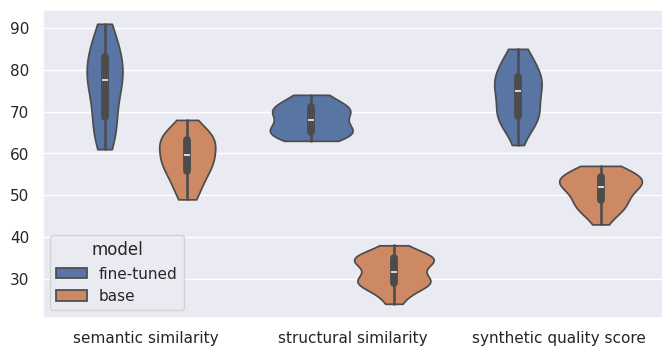

In [12]:
## DOWNLOAD RESULTS DIRECTLY HERE

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

sqs_results = pd.read_csv('https://gretel-blueprints-pub.s3.us-west-2.amazonaws.com/gpt_x/synth_notes_blogpost/sqs_results.csv.gz', compression='gzip')

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.violinplot(data=sqs_results, x='type', y='score', hue='model', cut=0, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')

### LLM-as-a-judge

Finally, we call a different, larger model (Claude 3.5 Sonnet) to act as "LLM-as-a-judge", i.e., to evaluate the quality of the generate notes, comparing them to the original note. We use the following prompt, where "note 1" will be the original note, and "note 2" is the note generated either by the fine-tuned model, or the base model.

We evaluate 3 different aspects: meaning, style and organization.

In [1]:
rubric = """
I will provide two clinical notes, note 1 and note 2, and I want you to compare them in the following aspects:

* Meaning: note 2 conveys the same meaning as note 1.
* Style: note 2 is written in the same style as note 1, considering potential quirks and mannerisms.
* Organization: note 2 is organized in the same fashion as note 1, in terms of sections and paragraphs.

For each of these aspects, I want you to produce a rating between 1 and 5, depending on how truthful are the statements above. Do not say anything else besides the ratings.
"""

content = """
*** NOTE 1 ***
{}

*** NOTE 2 ***
{}
"""

The following 2 cells will perform calls to Claude 3.5 Sonnet on Bedrock and parse the output to get the scores.

As before, you can skip them and obtain the rates directly from the 3rd cell.

In [ ]:
## SKIP TO DOWNLOAD RESULTS DIRECTLY

def get_ratings(i, finetuned=True, debug=False):
    data = generated_ft if finetuned else generated_base
    formatted_content = content.format(summaries.note.values[i], data[i])
    if debug:
        print(formatted_content)
    output = call_bedrock(formatted_content, system=rubric, model_id="anthropic.claude-3-5-sonnet-20240620-v1:0")
    return output

output = get_ratings(0, finetuned=False, debug=True)
print(output)

In [ ]:
## SKIP TO DOWNLOAD RESULTS DIRECTLY

import re
from tqdm import trange

COLUMNS = ["Meaning", "Style", "Organization"]
REGEX = "\n".join([f"{col}: ([1-5])" for col in COLUMNS])

def compute_rates(finetuned):
    """Parse output to get scores"""

    rates = pd.DataFrame([], columns=COLUMNS)
    for i in trange(1000):
        success = False
        attempts = 5

        while not success and attempts > 0:
            output = get_ratings(i, finetuned=finetuned)
            match = re.search(REGEX, output)

            if match and len(match.groups()) == len(rates.columns):
                rates.loc[len(rates)] = match.groups()
                success = True
            else:
                print(f'Failed to match for i = {i}')
                attempts -= 1

                if attempts == 0:
                    rates.loc[len(rates)] = (None, None)

    return rates

rates_base = compute_rates(finetuned=False)
rates_ft = compute_rates(finetuned=True)

In [13]:
## DOWNLOAD RESULTS DIRECTLY HERE

COLUMNS = ["Meaning", "Style", "Organization"]

rates_link = "https://gretel-blueprints-pub.s3.us-west-2.amazonaws.com/gpt_x/synth_notes_blogpost/rates.tar.gz"
with requests.get(rates_link, stream=True) as req, tarfile.open(fileobj=req.raw, mode="r:gz") as tarobj: 
    tarobj.extractall()

rates_ft = pd.read_csv("rates_ft.csv")
rates_base = pd.read_csv("rates_base.csv")

In [14]:
# Compare scores to get win/lose rates
comparison = pd.DataFrame([], columns=COLUMNS)
for i in range(1000):
    comparison.loc[i] = (0, 0, 0)
    for col in comparison.columns:
        if rates_ft.loc[i, col] > rates_base.loc[i, col]:
            comparison.loc[i, col] = 1
        elif rates_ft.loc[i, col] < rates_base.loc[i, col]:
            comparison.loc[i, col] = -1

llm_judge_res = pd.DataFrame([], columns=['base won', 'tie', 'fine-tuned won'])
for col in COLUMNS:
    llm_judge_res.loc[len(llm_judge_res)] = comparison[col].value_counts().sort_index().values
llm_judge_res.index = COLUMNS

llm_judge_res = llm_judge_res.melt(var_name='status', ignore_index=False).rename_axis('type').reset_index()
llm_judge_res

,type,status,value
0,Meaning,base won,231
1,Style,base won,32
2,Organization,base won,32
3,Meaning,tie,586
4,Style,tie,346
5,Organization,tie,240
6,Meaning,fine-tuned won,183
7,Style,fine-tuned won,622
8,Organization,fine-tuned won,728


/tmp/ipykernel_754194/3100595634.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.cumsum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  llm_judge_res_cum['value'] = llm_judge_res.groupby('type').cumsum()['value']


(0.0, 1000.0)

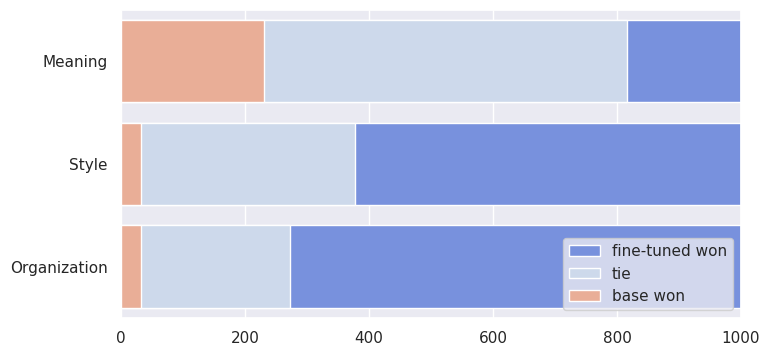

In [15]:
# Compute cumulative results
llm_judge_res_cum = llm_judge_res.copy()
llm_judge_res_cum['value'] = llm_judge_res.groupby('type').cumsum()['value']
llm_judge_res_cum

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
colors = sns.color_palette("coolwarm")
for status, color in zip(llm_judge_res['status'].unique()[::-1], colors[::2]):
    sns.barplot(data=llm_judge_res_cum[llm_judge_res['status'] == status], x='value', y='type', label=status, color=color, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim([0, 1000])

We can see that in terms of meaning, base and fine-tuned models are essentially tied; however, in terms of style and organization, the fine-tuned model does much better.